<font color=red> **Team name: The WAY**

**Students: Wassim BOUATAY - Amrou CHOUCHENE - Yassine NAJI**
</font>

# Import libraries and Mount the drive

In [1]:
from google.colab import drive
import os
import h5py
from PIL import Image
import pandas as pd
from skimage import io
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score ,accuracy_score, f1_score, precision_score, recall_score
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import h5py
from xgboost import XGBClassifier


from tqdm import tqdm

import warnings 
warnings.simplefilter("ignore")

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


# Loading Data

In [3]:
path_data =  '/content/drive/My Drive/Challenge'
path_file = '/content/drive/My Drive/'
train_csv = pd.read_csv(path_data+"/trainset/trainset_true.csv")  
train_csv

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.20
1,P183,1,M,5/15/1942,12.80
2,P89,1,M,6/19/1935,9.60
3,P123,1,M,1/27/1931,122.60
4,P61,1,F,3/5/1931,11.60
...,...,...,...,...,...
158,P135,1,M,27-08-1951,9.45
159,P8,0,M,16-05-1975,4.91
160,P130,0,F,16-05-1943,4.17
161,P70,1,M,05-09-1987,5.66


In [4]:
test_csv = pd.read_csv(path_data+"/testset/testset_data.csv")  

In [5]:
def csv_processing(features):
  def calculate_age(born):
    today = date.today()
    try:
      [day, month, year] = [int(i) for i in born.split("/")]
    except:
      [day, month, year] = [int(i) for i in born.split("-")]
    return today.year - year - ((today.month, today.day) < (month, day))

  features["DOB"] = features["DOB"].apply(calculate_age)
  features["GENDER"] = features["GENDER"].apply(lambda s:0 if s=='M' else 1)

  features["model_output"] = [0]*len(features)

  return features 

train_csv_preprocessed = csv_processing(train_csv)
test_csv_preprocessed = csv_processing(test_csv)

### Split with stratification

In [6]:
aux_data = train_csv_preprocessed.copy(deep=True)

## Quantize age
dob_splits = list(aux_data['DOB'].sort_values()[0::len(aux_data)//2]) ## into 2 equal intervals
print("Age intervals:", dob_splits)
def Quantize_age(x):
  for i in range(1, len(dob_splits)):
    if x<dob_splits[i]:
      return i
  return len(dob_splits)-1
aux_data['DOB'] = aux_data['DOB'].apply(Quantize_age)

## Quantize Lymph_count
Lymph_splits = list(aux_data['LYMPH_COUNT'].sort_values()[0::len(aux_data)//2]) ## into 2 equal intervals
print("LYMPH_COUNT intervals:", Lymph_splits)
def Quantize_lymph(x):
  for i in range(1, len(Lymph_splits)):
    if x<Lymph_splits[i]:
      return i
  return len(Lymph_splits)-1
aux_data['LYMPH_COUNT'] = aux_data['LYMPH_COUNT'].apply(Quantize_lymph)

Age intervals: [22, 72, 99]
LYMPH_COUNT intervals: [2.28, 7.81, 295.0]


In [7]:
train_csv, val_csv = train_test_split(train_csv_preprocessed, random_state=45, 
                                      test_size=0.2, shuffle=True, 
                                      stratify=aux_data[['LABEL', 'GENDER', 'DOB', 'LYMPH_COUNT']])
print(len(train_csv), len(val_csv))
train_csv.head(7)

130 33


,ID,LABEL,GENDER,DOB,LYMPH_COUNT,model_output
138,P95,0,0,39,5.93,0
74,P181,1,1,86,17.44,0
65,P51,1,1,74,4.97,0
50,P53,1,1,88,15.25,0
100,P193,1,0,84,10.42,0
142,P198,0,0,43,4.50,0
31,P157,1,0,71,5.05,0


## h5 files

In [9]:
f_train = h5py.File(path_data + '/train_data_h.h5', 'r')
f_val = h5py.File(path_data + '/val_data_h.h5', 'r')
f_test = h5py.File(path_data + '/test_data_h.h5', 'r')

#f_train_seg = h5py.File(path_data + '/train_data_seg_h.h5', 'r')
#f_val_seg = h5py.File(path_data + '/val_data_seg_h.h5', 'r')

# f_train = h5py.File(path_file + '/train_data_h.h5', 'r')
# f_val = h5py.File(path_file + '/val_data_h.h5', 'r')
# f_test = h5py.File(path_file + '/test_data_h.h5', 'r')
# f_test_seg = h5py.File(path_data + '/test_data_seg_h.h5', 'r')

#### Data Loader

In [10]:
class Lympho_Dataset(Dataset):

    def __init__(self, file, csv_file , transform=None):
        self.data = file
        self.transform = transform
        self.csv_data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient = list(self.data.keys())[idx]
        images = []
        for img in self.data[patient]:
            if self.transform:
              img = self.transform(img)
            images.append(img)

        target = torch.tensor(int(self.csv_data.loc[self.csv_data["ID"]==patient]['LABEL']))

        return images, target, patient

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

img_size = 128   ## original 224
train_data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(30, fill=None),
    transforms.ToTensor(),
])

test_data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])

trainset = Lympho_Dataset(file = f_train, csv_file=train_csv_preprocessed, transform=train_data_transforms)
#trainset_seg = Lympho_Dataset(file = f_train_seg, csv_file=train_csv_preprocessed, transform=train_data_transforms)
valset = Lympho_Dataset(file = f_val,csv_file=train_csv_preprocessed, transform=train_data_transforms)
#valset_seg = Lympho_Dataset(file = f_val_seg, csv_file=train_csv_preprocessed, transform=train_data_transforms)

testset = Lympho_Dataset(file = f_test, csv_file=test_csv_preprocessed, transform=test_data_transforms)

# Data exploration

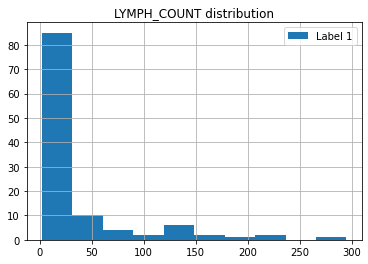

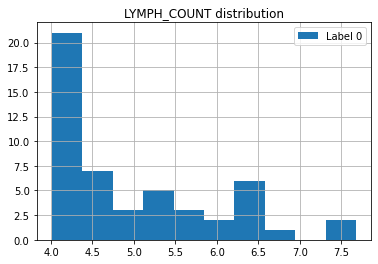

In [ ]:
train_csv_preprocessed['LYMPH_COUNT'][train_csv_preprocessed['LABEL'] == 1].hist(LABEL="Label 1")
plt.title("LYMPH_COUNT distribution")
plt.legend()
plt.show()
train_csv_preprocessed['LYMPH_COUNT'][train_csv_preprocessed['LABEL'] == 0].hist(LABEL="Label 0")
plt.title("LYMPH_COUNT distribution")
plt.legend()
plt.show()

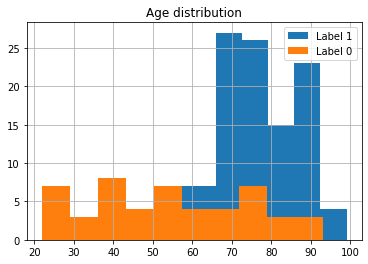

In [ ]:
train_csv_preprocessed['DOB'][train_csv_preprocessed['LABEL'] == 1].hist(LABEL="Label 1")
train_csv_preprocessed['DOB'][train_csv_preprocessed['LABEL'] == 0].hist(LABEL="Label 0")
plt.title("Age distribution")
plt.legend()
plt.show()

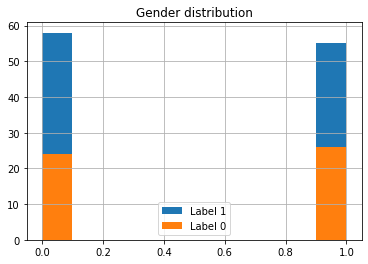

In [ ]:
train_csv_preprocessed['GENDER'][train_csv_preprocessed['LABEL'] == 1].hist(LABEL="Label 1")
train_csv_preprocessed['GENDER'][train_csv_preprocessed['LABEL'] == 0].hist(LABEL="Label 0")
plt.title("Gender distribution")
plt.legend()
plt.show()

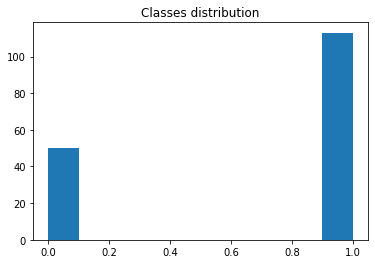

In [ ]:
plt.hist(train_csv_preprocessed['LABEL'].values)
plt.title('Classes distribution')
plt.show()

# Instance-Level MIL with Resnet18/Pretrained_Resnet18/SEnet

In [12]:
#ResNet18 implementation
#We used the implementation of ResNet18 architecture from the given github repository:
#https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        #print(out.size())
        #out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


In [13]:
"""

'''SENet in PyTorch.
SENet is the winner of ImageNet-2017. The paper is not released yet.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w  # New broadcasting feature from v0.2!

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w

        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        #print(out.size())
        #out = self.linear(out)
        return out


def SENet18():
    return SENet(PreActBlock, [2,2,2,2])
"""

"\n\n'''SENet in PyTorch.\nSENet is the winner of ImageNet-2017. The paper is not released yet.\n'''\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n\nclass BasicBlock(nn.Module):\n    def __init__(self, in_planes, planes, stride=1):\n        super(BasicBlock, self).__init__()\n        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\n        self.bn1 = nn.BatchNorm2d(planes)\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)\n        self.bn2 = nn.BatchNorm2d(planes)\n\n        self.shortcut = nn.Sequential()\n        if stride != 1 or in_planes != planes:\n            self.shortcut = nn.Sequential(\n                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),\n                nn.BatchNorm2d(planes)\n            )\n\n        # SE layers\n        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear\n     

In [14]:
def pretrained_resnet18(nclasses=2):
  pretrained_res = models.resnet18(pretrained=True)
  ct = 0
  for child in pretrained_res.children():
    ct += 1
    if 0<ct<4:
      for param in child.parameters():
        param.requires_grad = False

  num_param = pretrained_res.fc.in_features
  pretrained_res.fc = torch.nn.Sequential(
                      torch.nn.Linear(num_param, 64),
                      torch.nn.ReLU(),
                      torch.nn.Linear(64, nclasses))
  return pretrained_res

In [20]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

print('Building model')
net = pretrained_resnet18()

#setting the hyper-parameters
lr = 0.5
weight_d = 5e-4
momentum = 0.8
batch_size = 1
epochs = 4

#Opimizer and Loss criterion
ratio_label1 = 98/142 
weight = torch.tensor([ratio_label1, 1-ratio_label1]).cuda()
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_d)
#optimizer = torch.optim.Adam(net.parameters(), lr=lr) 


# Train and test 
def train(net, epochs, trainset, valset, prints=1):

    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    
    training_loss=[]
    train_accuracy=[]
    validation_loss=[]
    validation_accuracy=[]
    
    for epoch in range(epochs):
        #Training
        net.train()
        train_loss = 0
        total = 0
        y_pred = []
        y_truth = []
        
        for i in range(len(trainset)):
            outputs = 0
            images, targets, patient = trainset[i]            
      
            targets = targets.unsqueeze(0)
            targets = targets.to(device)
            for image in images:
              image = image.unsqueeze(0)
              image = image.to(device)
              outputs += net(image)
            outputs /= len(images)

            ## Adding the model prediction into the dataset
            train_csv_preprocessed["model_output"].loc[train_csv_preprocessed["ID"]==patient] = outputs.data.max(1, keepdim=True)[1][0].item()

            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            y_pred.append(predicted.item())
            y_truth.append(targets.item())

            if i%20==0:
              print("{}/{}".format(i, len(trainset)))

        t_accuracy = balanced_accuracy_score(y_truth, y_pred)
        t_loss = train_loss/ len(trainset)
        train_accuracy.append(t_accuracy)
        training_loss.append(t_loss)


        #Validation
        net.eval()
        val_loss = 0
        y_pred = []
        y_truth = []
        total = 0
        for i in range(len(valset)):
            outputs = 0
            images, targets, patient = valset[i]

            targets = targets.unsqueeze(0)
            targets = targets.to(device)
            for image in images:
              image = image.unsqueeze(0)
              image = image.to(device)
              outputs += net(image)
            outputs /= len(images)

            ## Adding the model prediction into the dataset
            train_csv_preprocessed["model_output"].loc[train_csv_preprocessed["ID"]==patient] = outputs.data.max(1, keepdim=True)[1][0].item()

            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            y_pred.append(predicted.item())
            y_truth.append(targets.item())

        print("predictions:", y_pred)
        v_accuracy = balanced_accuracy_score(y_truth, y_pred)
        v_loss = val_loss/ len(valset)
        validation_accuracy.append(v_accuracy)
        validation_loss.append(v_loss)

        if (epoch+1) % prints==0:
          print('Epoch [{}/{}],\t Train Loss: {:.4f}, \t Train accuracy={:.4f},\t Validation Loss: {:.4f}, \t Validation accuracy={:.4f}'
                          .format(epoch+1, epochs, t_loss , t_accuracy , v_loss, v_accuracy))
        
        torch.save(net.state_dict(), 'model.pth')

    return train_accuracy , training_loss , validation_accuracy , validation_loss

Building model


### Training the model

In [21]:
print("Training phase")
train_accuracy , training_loss , validation_accuracy , validation_loss = train(net, epochs, trainset, valset)

Training phase
0/130
20/130
40/130
60/130
80/130
100/130
120/130
predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch [1/4],	 Train Loss: 1.8062, 	 Train accuracy=0.5278,	 Validation Loss: 1.5535, 	 Validation accuracy=0.5000
0/130
20/130
40/130
60/130
80/130
100/130
120/130
predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch [2/4],	 Train Loss: 0.9887, 	 Train accuracy=0.5653,	 Validation Loss: 1.5534, 	 Validation accuracy=0.5000
0/130
20/130
40/130
60/130
80/130
100/130
120/130
predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch [3/4],	 Train Loss: 0.9887, 	 Train accuracy=0.5653,	 Validation Loss: 1.5533, 	 Validation accuracy=0.5000
0/130
20/130
40/130
60/130
80/130
100/130
120/130
predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Applying a Classifier on the new data

In [22]:
from sklearn.model_selection import train_test_split

y = train_csv_preprocessed['LABEL']
X = train_csv_preprocessed.drop(["ID", "LABEL"], axis=1).values
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier( learning_rate=0.5 , n_estimators=50 , n_jobs=-1 , verbosity=1)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_val)
print("Balancer Accuracy =", balanced_accuracy_score(y_val, y_pred))

Balancer Accuracy = 0.9090909090909092


### New Testset

In [29]:
from tqdm import tqdm
import os
import PIL.Image as Image
import torch

test_dir = path_data + '/testset'


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

for idx in range(len(test_csv)):
    if (idx)%10==0:
      print(idx)
    images, target, patient = testset[idx]
    if use_cuda:
        target = target.cuda().unsqueeze(0)

    output = 0
    for data in images:
      data = data.cuda().unsqueeze(0)
      output += net(data)
    output /= len(images)
    pred=output.data.max(1, keepdim=True)[1].item()  
    test_csv["model_output"].loc[test_csv["ID"]==patient] = pred 

0
10
20
30
40


## Submission file

In [30]:
test_ID = test_csv["ID"]
x_test = test_csv.drop(["ID", "LABEL"], axis=1)

output_file = open('kaggle1.csv', "w")
output_file.write("ID,Predicted\n")

for idx in range(len(test_csv)):
    pred = xgb.predict(x_test.iloc[idx])[0]
    output_file.write("%s,%d\n" % (test_csv.iloc[idx, 0], pred))

output_file.close()
print("Succesfully wrote " + 'kaggle1.csv' + ', you can upload this file to the kaggle competition website')


Succesfully wrote kaggle1.csv, you can upload this file to the kaggle competition website


# Deep MIL

### Loading encoder-decoder's features

In [31]:
train_data = pd.read_csv(path_data + '/train_features_8192.csv')
val_data = pd.read_csv(path_data + '/val_features_8192.csv')
train_data = pd.concat([train_data, val_data])
print(train_data.shape)

train_patients = pd.unique(train_csv['ID'])
val_patients = pd.unique(val_csv['ID'])

(13453, 8196)


In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

nc = 3000
pca = PCA(n_components=nc)
data = train_data[[f'image_features_{k}' for k in range(8192)]].values
scaler = StandardScaler() 
data = scaler.fit_transform(data)
aux_pca = pca.fit_transform(data)

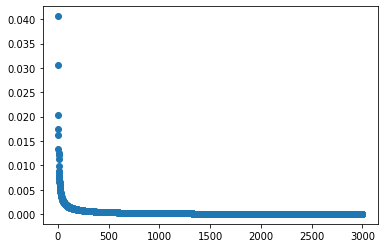

In [33]:
plt.scatter(range(nc), pca.singular_values_/np.sum(pca.singular_values_))

In [34]:
aux = np.column_stack((train_data['ID_patient'], aux_pca.astype(np.float16)))
train_pca = pd.DataFrame(data = aux, columns = ['ID_patient']+[f'pca_features_{k}' for k in range(nc)])
train_pca.head(5)

,ID_patient,pca_features_0,pca_features_1,pca_features_2,pca_features_3,pca_features_4,pca_features_5,pca_features_6,pca_features_7,pca_features_8,pca_features_9,pca_features_10,pca_features_11,pca_features_12,pca_features_13,pca_features_14,pca_features_15,pca_features_16,pca_features_17,pca_features_18,pca_features_19,pca_features_20,pca_features_21,pca_features_22,pca_features_23,pca_features_24,pca_features_25,pca_features_26,pca_features_27,pca_features_28,pca_features_29,pca_features_30,pca_features_31,pca_features_32,pca_features_33,pca_features_34,pca_features_35,pca_features_36,pca_features_37,pca_features_38,...,pca_features_2960,pca_features_2961,pca_features_2962,pca_features_2963,pca_features_2964,pca_features_2965,pca_features_2966,pca_features_2967,pca_features_2968,pca_features_2969,pca_features_2970,pca_features_2971,pca_features_2972,pca_features_2973,pca_features_2974,pca_features_2975,pca_features_2976,pca_features_2977,pca_features_2978,pca_features_2979,pca_features_2980,pca_features_2981,pca_features_2982,pca_features_2983,pca_features_2984,pca_features_2985,pca_features_2986,pca_features_2987,pca_features_2988,pca_features_2989,pca_features_2990,pca_features_2991,pca_features_2992,pca_features_2993,pca_features_2994,pca_features_2995,pca_features_2996,pca_features_2997,pca_features_2998,pca_features_2999
0,P0,-7.80859,-4.95703,0.538574,-0.170044,0.205688,-0.618164,-0.461182,0.00378418,0.513184,-0.0651855,0.283203,0.0568542,0.0682983,-0.0685425,-0.0720825,-0.158936,0.403076,-0.736816,-0.0233917,0.0241241,-0.718262,-0.0226746,-0.185303,0.231079,-0.0736084,0.417969,-0.04422,-0.35376,0.36499,0.442871,0.943359,-0.0932617,0.294434,0.375244,0.0808105,-0.139771,0.0353088,-0.660156,0.904297,...,-0.00172424,0.00375175,-0.0308533,-0.0209808,0.0261688,-0.0155029,0.0125275,0.0189667,-0.0127945,-0.0262909,0.0132217,-0.017807,-0.0236816,-0.0392456,0.016098,-0.0218201,-0.0204315,0.00421143,0.00954437,0.025116,-0.0170135,-0.0068779,0.00644302,-0.0302277,-0.0180206,-0.0164642,0.0103455,0.00328255,-0.00297165,0.0333252,0.0149765,-0.0159302,0.0122757,0.018158,0.00135612,0.035614,0.000208259,-0.0108566,0.0236053,0.0263672
1,P0,-8,-5.57422,0.201294,-0.0273743,-0.0041008,-0.0242462,-0.901367,-0.415771,1.07031,0.180664,0.438965,0.032135,0.649902,0.0493774,-0.317139,-0.63916,-0.0502625,-0.783691,0.199097,-0.199463,-0.944336,-0.190186,-0.0595703,1.07812,-0.0872803,0.524902,0.140625,-0.667969,0.0191193,1.1748,1.68555,-0.670898,0.0806274,1.03613,-0.00132561,0.908203,-0.258789,-1.88184,-0.883789,...,0.000916004,0.00820923,0.0148849,0.00590897,0.00330734,-0.00779343,-0.0343323,0.01371,-0.0114059,0.0125046,-0.0232239,0.0138702,-0.00417709,-0.0338745,0.00348473,0.00126362,0.0119553,-0.00222778,0.00580978,0.00985718,-0.0141907,-0.00744247,-0.0102615,0.0104218,-0.00816345,-0.0175171,-0.00809479,-0.00875854,0.00225639,0.0240631,0.0083313,0.0189972,-0.00699615,-0.00749969,-0.0139542,-0.00823975,-0.000359774,0.00596237,-0.0328064,-0.0152512
2,P0,-7.75781,-4.60156,-0.225098,-0.54541,0.720703,0.180908,-0.754883,-0.644043,1.33496,0.350342,0.320801,-0.357422,0.534668,0.44043,-0.190796,-0.868164,0.364258,-0.262695,0.272705,0.130005,-1.55957,0.526367,-0.125244,1.12988,-0.968262,0.930176,0.0786133,-0.127563,-0.510254,0.79541,0.386475,-0.441162,-0.293701,0.243408,-0.101685,0.623535,-0.307861,-0.794922,-1.49805,...,0.0187225,-0.00322914,-0.00375748,0.00791931,-0.0100021,-0.0150757,0.00691605,-0.0361023,0.0114822,-0.00952911,-0.00677872,-0.0276947,0.00217056,-0.00835419,-0.00196075,-0.0220337,0.00328255,0.00463104,-0.0299072,-0.00439453,-0.00174809,-0.00632095,-0.00589371,0.00071764,-0.00070715,-0.0110245,0.00971985,0.00936127,0.0212097,-0.0294952,-0.00588226,0.00385475,-0.00214386,0.0154343,-0.0135498,-0.000608444,0.0113373,0.0282898,0.00101376,-0.0363464
3,P0,-7.75391,-4.54297,0.38501,-0.752441,0.755859,-0.526367,-0.445557,0.00139427,1.05762,0.499023,0.522461,-0.135376,0.160034,-0.00919342,0.0238647,-0.374756,-0.136719,-0.606445,0.870605,-0.055084

### Architecture

In [35]:
class layer(nn.Module):
  def __init__(self, input, output, droprate=0.0):
      super(layer, self).__init__()
      self.l = nn.Linear(input, output)
      self.act = nn.ReLU()
      self.norm = nn.LayerNorm(output)
      self.drop = nn.Dropout(droprate)

  def forward(self, inputs):
      out = self.act(self.l(inputs))
      out = self.norm(out)
      out = self.drop(out)
      return out

class DeepSets_fixed_features(nn.Module):
  def __init__(self, activation = nn.ReLU(), device = 'cuda', L=64, f=64, M=512, x=4, y=2, droprate=0.25):
    super(DeepSets_fixed_features, self).__init__()
    self.L = L
    self.M = M  ## dimension of the embedding
    self.f = f
    self.x = x
    self.y = y
    self.activation = activation


    ## Attention
    self.attention = nn.Sequential(nn.Linear(nc, self.L),
                                   nn.Tanh(),
                                   nn.Linear(self.L, 1))  

    ## applied to features
    self.image_layers = []  
    self.image_layers.append(layer(nc, self.M, droprate))
    for i in range(y):
      self.image_layers.append(layer(self.M, self.M, droprate))
    self.image_layers = nn.Sequential(*self.image_layers)  

    ## Applied to data
    self.data_layers = []  
    self.data_layers.append(layer(2, self.f, droprate))
    for i in range(y):
      self.data_layers.append(layer(self.f, self.f, droprate))
    self.data_layers = nn.Sequential(*self.data_layers)

    ## Applied to features + data
    self.final_layer = nn.Linear(self.f + self.M, 2)
    self.device = device
  

  def forward(self , images , data):
    bag_of_features = []
    for image in images : 
      features = image.unsqueeze(0).type(torch.FloatTensor).to(self.device)
      bag_of_features.append(features)

    bag_of_features = torch.stack(bag_of_features) ### Nx1xM
    bag_of_features1 = torch.max(torch.squeeze(bag_of_features, axis=1), axis=0)[0] ### NxM
    bag_of_features2 = torch.mean(torch.squeeze(bag_of_features, axis=1), axis=0) 
    bag_of_features3 = torch.std(torch.squeeze(bag_of_features, axis=1), axis=0)

    attention = self.attention(bag_of_features).squeeze() ### Nx1
    attention = F.softmax(attention)
    bag_of_features4 = ((bag_of_features.T) @ attention) ### 1xM

    bag_of_features = self.image_layers(bag_of_features4.T)
  
    data_features = self.data_layers(data)
    out = torch.cat((bag_of_features, data_features), 1)
    out = self.final_layer(out)

    return out

In [36]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

# Train and test 
def train_deep_sets_with_prepared_features(net, epochs, prints=1):    
    training_loss=[]
    train_accuracy=[]
    validation_loss=[]
    validation_accuracy=[]
    best_loss = 10
    best_acc = 0
    p = 10
    metrics = []
    
    for epoch in range(epochs):
        train_loss = 0
        y_pred = []
        y_truth = []
        total = 0
                
        for patient in train_patients:
            bag = torch.tensor(train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float))
            data = torch.Tensor(train_csv_preprocessed[['LYMPH_COUNT','DOB']].loc[train_csv_preprocessed["ID"]==patient].values)      
            targets = int(train_csv_preprocessed.loc[train_csv_preprocessed['ID'] == patient]['LABEL'])
            targets = torch.tensor(targets).to(device).unsqueeze(0)
            outputs = net(bag , data)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            y_pred.append(predicted.item())
            y_truth.append(targets.item())

        t_accuracy = balanced_accuracy_score(y_truth, y_pred)
        t_loss = train_loss/ len(train_patients)
        train_accuracy.append(t_accuracy)
        training_loss.append(t_loss)

        #Validation
        net.eval()
        val_loss = 0
        y_pred = []
        y_truth = []
        total = 0
        for patient in val_patients:
            bag = torch.tensor(train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float))
            data = torch.Tensor(train_csv_preprocessed[['LYMPH_COUNT','DOB']].loc[train_csv_preprocessed["ID"]==patient].values)      
            targets = int(train_csv_preprocessed.loc[train_csv_preprocessed['ID'] == patient]['LABEL'])
            targets = torch.tensor(targets).to(device).unsqueeze(0)

            outputs = net(bag , data)
            loss = criterion(outputs, targets) 

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            y_pred.append(predicted.item())
            y_truth.append(targets.item())


        v_balanced_accuracy = balanced_accuracy_score(y_truth, y_pred)
        v_recall = recall_score(y_truth, y_pred)
        v_precision = precision_score(y_truth, y_pred)
        v_f1 = f1_score(y_truth, y_pred)
        v_loss = val_loss/ len(val_patients)
        validation_accuracy.append(v_balanced_accuracy)
        validation_loss.append(v_loss)
        scheduler.step(v_balanced_accuracy)


        if (epoch+1) % prints==0:
          print("""Epoch [{}/{}],\t Train Loss: {:.4f}, \t Train accuracy={:.4f}%,\t Validation Loss: {:.4f},
           Validation Balanced accuracy={:.4f}%, \t Validation F1 score={:.4f}, \t Validation Recall={:.4f}, \t Validation Precision={:.4f}"""
                          .format(epoch+1, epochs, t_loss , t_accuracy , v_loss, v_balanced_accuracy, v_f1, v_recall, v_precision))


        if (v_loss - 0.05 < best_loss and v_balanced_accuracy >= best_acc) or (v_loss - 0.05 < best_loss and v_balanced_accuracy == best_acc):
          best_loss = min(v_loss, best_loss)
          best_acc = v_balanced_accuracy
          metrics = [v_f1, v_recall, v_precision]
          torch.save(net.state_dict(), 'model.pth')
          if prints == 1:
            print("saved model...")
          p = 10
        else:
          p -= 1
        
        if prints == 1:
          print()

    return train_accuracy , training_loss , validation_accuracy , validation_loss, best_acc, best_loss, metrics

In [40]:
n = 7
acc = np.zeros(n)
loss = np.zeros(n)
metric = np.zeros((n, 3))

lr = 1e-6
weight_d = 1e-4
momentum = 0.5
batch_size = 1
ratio_label1 = 98/142 
weight = torch.tensor([1-ratio_label1, ratio_label1]).cuda()
criterion = nn.CrossEntropyLoss(weight)

train_accuracys, training_losss, validation_accuracys, validation_losss = [0]*n, [0]*n, [0]*n, [0]*n

for i in range(n):
  print("i=", i)

  net = DeepSets_fixed_features(L=64, f=128, M=128, x=1, y=1, droprate=0.05)
  net = net.to(device)
  if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_d) 
  #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_d)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=3, min_lr=1e-7, verbose=True)

  train_accuracys[i], training_losss[i], validation_accuracys[i], validation_losss[i], acc[i], loss[i], metrics = train_deep_sets_with_prepared_features(net, epochs=25, prints=50)
  metric[i] = np.array(metrics)

print("mean \t \t std \t \t max")
print("balanced Accuracy ")
print(acc.mean(), acc.std(), acc.max())
print("f1-score")
print(metric.mean(axis=0)[0], metric.std(axis=0)[0], metric.max(axis=0)[0])
print("Recall")
print(metric.mean(axis=0)[1], metric.std(axis=0)[1], metric.max(axis=0)[1])
print("Precision")
print(metric.mean(axis=0)[2], metric.std(axis=0)[2], metric.max(axis=0)[2])
print("BCE Loss")
print(loss.mean(), loss.std(), loss.min())

i= 0
Epoch     5: reducing learning rate of group 0 to 8.0000e-07.
Epoch    14: reducing learning rate of group 0 to 6.4000e-07.
Epoch    18: reducing learning rate of group 0 to 5.1200e-07.
Epoch    22: reducing learning rate of group 0 to 4.0960e-07.
i= 1
Epoch    13: reducing learning rate of group 0 to 8.0000e-07.
Epoch    17: reducing learning rate of group 0 to 6.4000e-07.
Epoch    25: reducing learning rate of group 0 to 5.1200e-07.
i= 2
Epoch     9: reducing learning rate of group 0 to 8.0000e-07.
Epoch    13: reducing learning rate of group 0 to 6.4000e-07.
Epoch    17: reducing learning rate of group 0 to 5.1200e-07.
Epoch    21: reducing learning rate of group 0 to 4.0960e-07.
Epoch    25: reducing learning rate of group 0 to 3.2768e-07.
i= 3
Epoch    12: reducing learning rate of group 0 to 8.0000e-07.
Epoch    16: reducing learning rate of group 0 to 6.4000e-07.
Epoch    20: reducing learning rate of group 0 to 5.1200e-07.
Epoch    24: reducing learning rate of group 0 to 

In [41]:
train_accuracys = np.array(train_accuracys)
validation_accuracys = np.array(validation_accuracys)
training_losss = np.array(training_losss)
validation_losss = np.array(validation_losss)

mean_t_acc = train_accuracys.mean(axis=0)
std_t_acc = train_accuracys.std(axis=0)

mean_v_acc = validation_accuracys.mean(axis=0)
std_v_acc = validation_accuracys.std(axis=0)

mean_t_loss = training_losss.mean(axis=0)
std_t_loss = training_losss.std(axis=0)

mean_v_loss = validation_losss.mean(axis=0)
std_v_loss = validation_losss.std(axis=0)

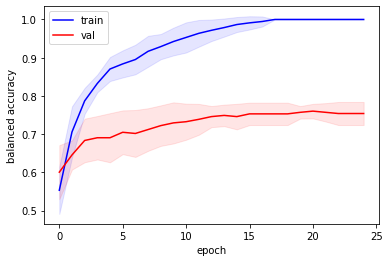

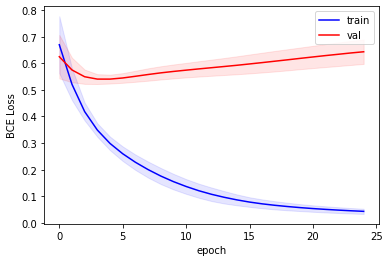

In [42]:
epoch = len(mean_t_acc)

plt.plot(range(epoch), mean_t_acc, label='train', color='b')
plt.fill_between(range(epoch),  mean_t_acc - std_t_acc, mean_t_acc + std_t_acc, alpha=0.1, color='b')
plt.plot(range(epoch), mean_v_acc, label='val', color='r')
plt.fill_between(range(epoch),  mean_v_acc - std_v_acc, mean_v_acc + std_v_acc, alpha=0.1, color='r')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('balanced accuracy')
plt.show()

plt.plot(range(epoch), mean_t_loss, label='train', color='b')
plt.fill_between(range(epoch),  mean_t_loss - std_t_loss, mean_t_loss + std_t_loss, alpha=0.1, color='b')
plt.plot(range(epoch), mean_v_loss, label='val', color='r')
plt.fill_between(range(epoch),  mean_v_loss - std_v_loss, mean_v_loss + std_v_loss, alpha=0.1, color='r')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE Loss')
plt.show()

#### Final training

In [45]:
print('Building model')
net = DeepSets_fixed_features(L=64, f=128, M=128, x=1, y=1, droprate=0.05)
net = net.to(device)
if device == 'cuda':
  net = torch.nn.DataParallel(net)
  cudnn.benchmark = True

#setting the hyper-parameters
lr = 1e-6
weight_d = 1e-4
momentum = 0.5
batch_size = 1

#Opimizer and Loss criterion
ratio_label1 = 98/142 
weight = torch.tensor([1-ratio_label1, ratio_label1]).cuda()
criterion = nn.CrossEntropyLoss(weight)

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_d) 
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_d)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=3, min_lr=1e-7, verbose=True)


train_accuracy, training_loss, validation_accuracy, validation_loss, acc, loss, metrics = train_deep_sets_with_prepared_features(net, epochs=15, prints=1)

Building model
Epoch [1/15],	 Train Loss: 0.6915, 	 Train accuracy=0.4778%,	 Validation Loss: 0.6295,
           Validation Balanced accuracy=0.4848%, 	 Validation F1 score=0.7692, 	 Validation Recall=0.8696, 	 Validation Precision=0.6897
saved model...

Epoch [2/15],	 Train Loss: 0.5508, 	 Train accuracy=0.6028%,	 Validation Loss: 0.5737,
           Validation Balanced accuracy=0.4848%, 	 Validation F1 score=0.7692, 	 Validation Recall=0.8696, 	 Validation Precision=0.6897
saved model...

Epoch [3/15],	 Train Loss: 0.4421, 	 Train accuracy=0.7347%,	 Validation Loss: 0.5409,
           Validation Balanced accuracy=0.5196%, 	 Validation F1 score=0.7234, 	 Validation Recall=0.7391, 	 Validation Precision=0.7083
saved model...

Epoch [4/15],	 Train Loss: 0.3659, 	 Train accuracy=0.8278%,	 Validation Loss: 0.5240,
           Validation Balanced accuracy=0.5913%, 	 Validation F1 score=0.7660, 	 Validation Recall=0.7826, 	 Validation Precision=0.7500
saved model...

Epoch [5/15],	 Train Loss

#### Testing

In [46]:
test_data = pd.read_csv(path_data + '/test_features_8192.csv')
data = test_data[[f'image_features_{k}' for k in range(8192)]].values
data = scaler.transform(data)
aux_pca = pca.transform(data)

aux = np.column_stack((test_data['ID_patient'], aux_pca.astype(np.float16)))
test_pca = pd.DataFrame(data = aux, columns = ['ID_patient']+[f'pca_features_{k}' for k in range(nc)])

test_patients = pd.unique(test_data['ID_patient'])

In [ ]:
output_file = open('kaggle1.csv', "w")
output_file.write("ID,Predicted\n")

for patient in test_patients:
  bag = torch.tensor(test_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float))
  data = torch.Tensor(test_csv_preprocessed[['LYMPH_COUNT','DOB']].loc[test_csv_preprocessed["ID"]==patient].values)
  outputs = net(bag , data)
  _, pred = outputs.max(1)
  output_file.write("%s,%d\n" % (patient, pred.item()))

output_file.close()
print("Succesfully wrote ")